In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
import scipy.stats as stats

### 1. Load the dataset into python environment

In [63]:
data=pd.read_csv(r"titanic_dataset(1).csv")

In [64]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



### Preprocessing
#### Handling Null Values

In [66]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

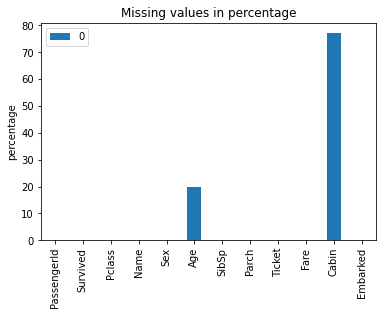

In [67]:
miss_value=pd.DataFrame(data.isna().sum()/len(data) *100)
miss_value.plot(kind="bar",title="Missing values in percentage", ylabel='percentage')
plt.show()

In [68]:
#we ill drop the column cabin
data.drop("Cabin",axis=1,inplace=True)
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

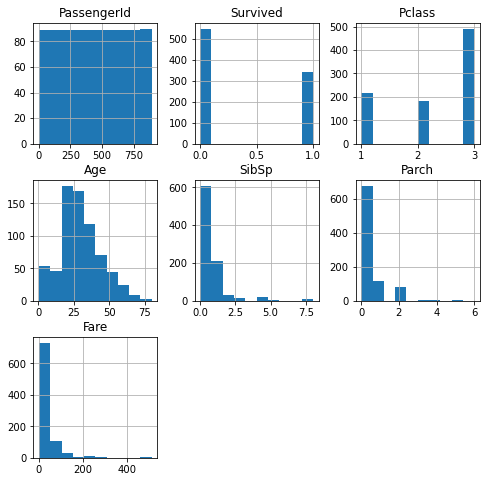

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

<Figure size 432x288 with 0 Axes>

In [69]:
# check the skeweness of the numerical field
numerical_data=data.select_dtypes(exclude="object")
numerical_data.hist(figsize=(8,8))
plt.show()
plt.tight_layout()
numerical_data.columns

In [70]:
# numerical features are  skewed, so we will use median to fill the null values in "Age" features
# we will fill the null values in categorical column "Embarked" with its mode
#data["Age"]=data["Age"].fillna(data["Age"].median())
from sklearn.impute import SimpleImputer

def get_parameters(data):
    parameters={}
    for i in data.columns[data.isnull().any()]:
        if data[i].dtype=="int64" or data[i].dtype=="float64":
            strategy="median"
        else:
            strategy="most_frequent"
        missing_values=data[i][data[i].isnull()].values[0]
        parameters[i]={"missing_values":missing_values,"strategy":strategy}
    return parameters
get_parameters(data)

{'Age': {'missing_values': nan, 'strategy': 'median'},
 'Embarked': {'missing_values': nan, 'strategy': 'most_frequent'}}

In [71]:
#Removing the null values
cols=["Age","Embarked"]
parameters=get_parameters(data)
for col,param in parameters.items():
    missing_values=param["missing_values"]
    strategy=param["strategy"]
    imp=SimpleImputer(missing_values=missing_values,strategy=strategy)
    data[col]=imp.fit_transform(data[[col]])
data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### Handling Outliers

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

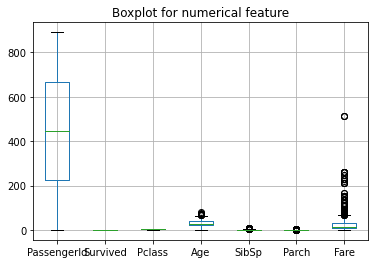

In [72]:
#Check for the outliers
numerical_data.boxplot()
plt.title("Boxplot for numerical feature")
numerical_data.columns

In [73]:
# Handling of Outliers
#1. Handling of outliers in Age
cols=['Age', 'SibSp', 'Parch', 'Fare']
# Calculating the IQR value "Age" and setting the lower & upper limit for the outliers
Q1=np.percentile(data["Age"],25,interpolation="midpoint")
Q2=np.percentile(data["Age"],50,interpolation="midpoint")
Q3=np.percentile(data["Age"],75,interpolation="midpoint")
IQR=Q3-Q1
low_lim=Q1-(1.5*IQR)
up_lim=Q3+(1.5*IQR)


In [74]:
# Replacing outlier with its lower & upper limits

data.loc[data["Age"] <low_lim,"Age"] = low_lim
data.loc[data["Age"] >up_lim,"Age"] = up_lim

In [75]:
# 2. Handling of outliers in SibSp
# Calculating the IQR value "SibSp" and setting the lower & upper limit for the outliers
Q1=np.percentile(data["SibSp"],25,interpolation="midpoint")
Q2=np.percentile(data["SibSp"],50,interpolation="midpoint")
Q3=np.percentile(data["SibSp"],75,interpolation="midpoint")
IQR=Q3-Q1
low_lim=Q1-(1.5*IQR)
up_lim=Q3+(1.5*IQR)

# Replacing outlier with its lower & upper limits

data.loc[data["SibSp"] <low_lim,"SibSp"] = low_lim
data.loc[data["SibSp"] >up_lim,"SibSp"] = up_lim


In [76]:
# 3. Handling of outliers in Parch
# Calculating the IQR value "Parch" and setting the lower & upper limit for the outliers
Q1=np.percentile(data["Parch"],25,interpolation="midpoint")
Q2=np.percentile(data["Parch"],50,interpolation="midpoint")
Q3=np.percentile(data["Parch"],75,interpolation="midpoint")
IQR=Q3-Q1
low_lim=Q1-(1.5*IQR)
up_lim=Q3+(1.5*IQR)

# Replacing outlier with its lower & upper limits

data.loc[data["Parch"] <low_lim,"Parch"] = low_lim
data.loc[data["Parch"] >up_lim,"Parch"] = up_lim

### EDA

In [78]:
#Creating a function to classify age to Age group
age_arr=data["Age"].values
def age_grouping(x):
    if 0<=x<10:
        return 1
    elif 10<=x<20:
        return 2
    elif 20<=x<30:
        return 3
    elif 30<=x<40:
        return 4
    elif 40<=x<50:
        return 5
    elif 50<=x<60:
        return 6

In [79]:
# Creating a new Columns Age group
data["Age_group"]=data["Age"].apply(lambda x:age_grouping(x) )
data["Age_group"].isna().sum()

0

		Survived vs Gender


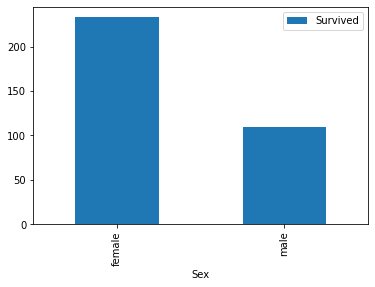

In [80]:
# Plotting the Survived count in terms of Gender
pd.pivot_table(index='Sex',values='Survived',data=data,aggfunc='sum').plot(kind='bar')
print("\t\tSurvived vs Gender")

		Survived vs Age Group


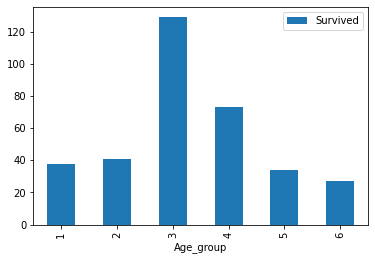

In [81]:
# Plotting the Survived count in terms of Age Group
pd.pivot_table(index="Age_group",values='Survived',data=data,aggfunc='sum').plot(kind='bar')
print("\t\tSurvived vs Age Group")

### Feature Engineering

In [82]:
# Encoding the catetgorical colum using pandas get dummies method
data["Sex"]=pd.get_dummies(data["Sex"],drop_first=True)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_group
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1.0,0,A/5 21171,7.2500,S,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1.0,0,PC 17599,71.2833,C,4
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0.0,0,STON/O2. 3101282,7.9250,S,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1.0,0,113803,53.1000,S,4
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0.0,0,373450,8.0500,S,4


In [83]:
#For Embarked feature also, we will apply get dummies method
data=pd.get_dummies(data, columns=['Embarked'],drop_first=True)

In [84]:
#drop feature "ticket"
data.drop(["Name","Ticket"],axis=1,inplace=True)
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Age_group,Embarked_Q,Embarked_S
0,1,0,3,1,22.0,1.0,0,7.2500,3,0,1
1,2,1,1,0,38.0,1.0,0,71.2833,4,0,0
2,3,1,3,0,26.0,0.0,0,7.9250,3,0,1
3,4,1,1,0,35.0,1.0,0,53.1000,4,0,1
4,5,0,3,1,35.0,0.0,0,8.0500,4,0,1


In [85]:
#SibSp shows no. of sibilings that the passenger travelled with
# parch shows no .of parents & children that the passenger travelled with
data["Family"]=data["SibSp"]+data["Parch"]
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Age_group,Embarked_Q,Embarked_S,Family
0,1,0,3,1,22.0,1.0,0,7.2500,3,0,1,1.0
1,2,1,1,0,38.0,1.0,0,71.2833,4,0,0,1.0
2,3,1,3,0,26.0,0.0,0,7.9250,3,0,1,0.0
3,4,1,1,0,35.0,1.0,0,53.1000,4,0,1,1.0
4,5,0,3,1,35.0,0.0,0,8.0500,4,0,1,0.0


In [86]:
# creating new feature Travelled Alone
data.loc[data["Family"]>0,'Travelled_Alone']=0
data.loc[data["Family"]==0,'Travelled_Alone']=1
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Age_group,Embarked_Q,Embarked_S,Family,Travelled_Alone
0,1,0,3,1,22.0,1.0,0,7.2500,3,0,1,1.0,0.0
1,2,1,1,0,38.0,1.0,0,71.2833,4,0,0,1.0,0.0
2,3,1,3,0,26.0,0.0,0,7.9250,3,0,1,0.0,1.0
3,4,1,1,0,35.0,1.0,0,53.1000,4,0,1,1.0,0.0
4,5,0,3,1,35.0,0.0,0,8.0500,4,0,1,0.0,1.0


<AxesSubplot:title={'center':'Passenger Travelled Alone?'}>

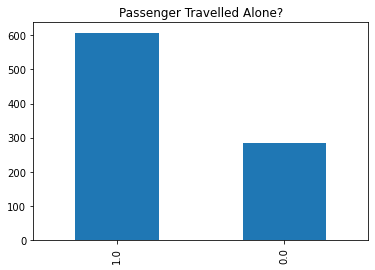

In [87]:
data.Travelled_Alone.value_counts().plot(kind="bar", title="Passenger Travelled Alone?")

<AxesSubplot:>

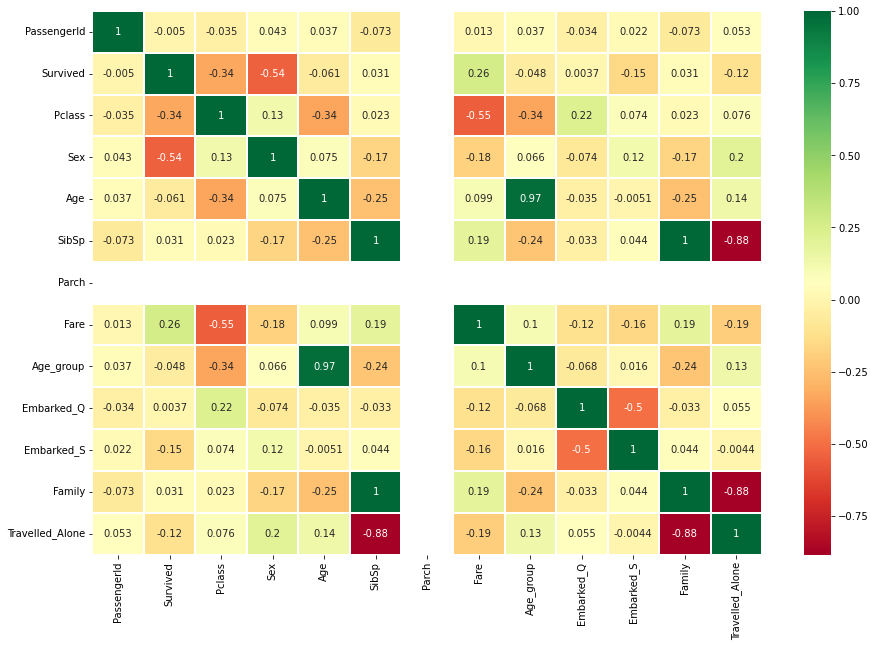

In [88]:
corrmatrix=data.corr()
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(corrmatrix,linewidths=0.2,cmap='RdYlGn',annot=True)

In [89]:
# Deleting the highly correlated columns
data.drop(["Age","SibSp","Parch","Family"],axis=1,inplace=True)

<AxesSubplot:>

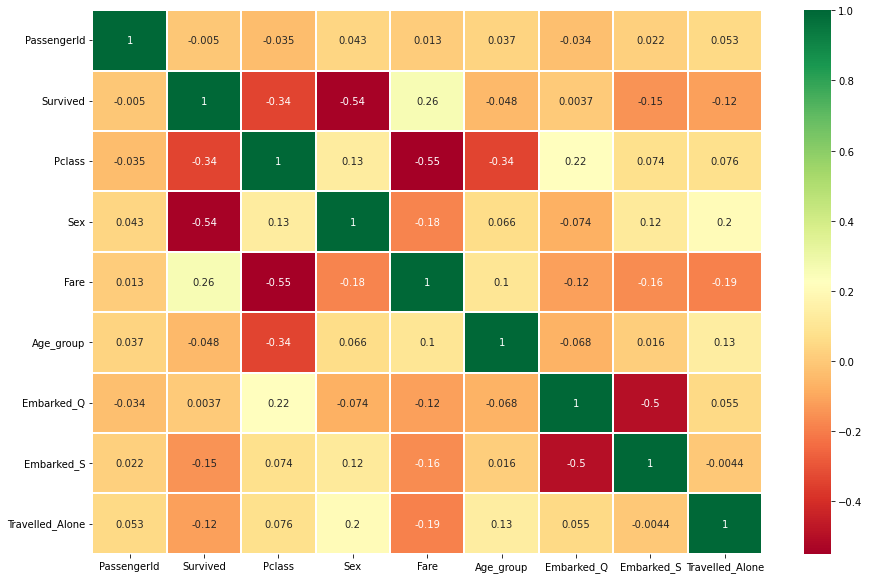

In [90]:
# Checking the correlation of Faetures 
corrmatrix=data.corr()
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(corrmatrix,linewidths=0.2,cmap='RdYlGn',annot=True)

In [91]:
#Splitting Data into dependant & Independent variables
y=data['Survived']
x=data.drop("Survived", axis=1)
# Splitting data into train & test set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train.shape
x_test.shape

(179, 8)

### Standard Scaling

In [92]:
std=StandardScaler()
x_train=std.fit_transform(x_train)
x_test=std.transform(x_test)

### Feature Selection

In [93]:
rdm=RandomForestClassifier()
rdm.fit(x_train,y_train)
feat_importances=pd.Series(rdm.feature_importances_,index=x.columns).sort_values(ascending=False)*100
feat_importances

PassengerId        26.332062
Sex                25.520338
Fare               24.221668
Age_group           9.557719
Pclass              8.917314
Embarked_S          2.305804
Travelled_Alone     2.250592
Embarked_Q          0.894504
dtype: float64

			Top 4 Best Features


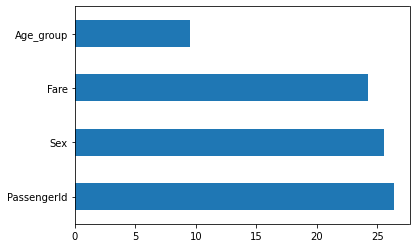

In [94]:
#We can drop columns with Low Feature importance
print("\t\t\tTop 4 Best Features")
feat_importances.nlargest(4).plot(kind='barh')
plt.show()

In [95]:
cols=x.columns
cols

Index(['PassengerId', 'Pclass', 'Sex', 'Fare', 'Age_group', 'Embarked_Q',
       'Embarked_S', 'Travelled_Alone'],
      dtype='object')

In [96]:
# Remove the all other columns from the dataset
feat_importances.nlargest(4).index
new_feature=['Pclass', 'Sex', 'Fare', 'Age_group', 'Embarked_Q', 'Embarked_S',
       'Travelled_Alone']
for k in cols:
    if k not in new_feature:
        x.drop(k,axis=1,inplace=True)

In [97]:
#spliting the data into train & Test set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


### Modeling

Text(0.5, 1.0, 'Accuracy for differnet K value')

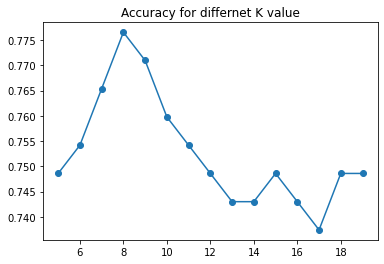

In [98]:
# Finding the best vaue of n_neighbors in KNN
n_nghbr=[]
lim=np.arange(5,20)

for i in lim:
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    y_pred=knn.predict(x_test)
    accur=accuracy_score(y_test,y_pred)
    n_nghbr.append(accur)
plt.plot(lim,n_nghbr,'-o')
plt.title("Accuracy for differnet K value")

In [99]:
# since its is Classification data, We can gor for Classifier algorithms
Model={
    'Logistic Regression':LogisticRegression(),
    'KNN Classifier':KNeighborsClassifier(n_neighbors=6, metric="minkowski"),
    'Random Forest Classifier':RandomForestClassifier(),
    'Decision Tree Classifier':DecisionTreeClassifier(),
    'Gradient Boosting Classifier':GradientBoostingClassifier(),
    'support vector': SVC(),
    'BernoulliNB':BernoulliNB()   
}

In [100]:
result={}

for name,model in Model.items():
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    result[name]=acc

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
result

{'Logistic Regression': 0.7932960893854749,
 'KNN Classifier': 0.7541899441340782,
 'Random Forest Classifier': 0.8268156424581006,
 'Decision Tree Classifier': 0.8100558659217877,
 'Gradient Boosting Classifier': 0.8156424581005587,
 'support vector': 0.6536312849162011,
 'BernoulliNB': 0.7821229050279329}